In [1]:
import math
import os
import random
import shutil
import pickle
import matplotlib.colors
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
# import tensorflow as tf
# import shap
import sys
import time

from simple_colors import *
from scipy.stats import ttest_ind
from scipy.special import softmax
from sklearn.metrics import accuracy_score
# from tensorflow import keras
# from tensorflow.keras.utils import plot_model
# from tensorflow.keras import layers
# from tensorflow.keras.preprocessing.text import Tokenizer

SEED_VALUE = 11
os.environ['PYTHONHASHSEED']=str(SEED_VALUE)
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
# tf.random.set_seed(SEED_VALUE)
warnings.filterwarnings('ignore')
os.chdir(os.getcwd())

from analysis.dataset_composition import Dataset_composition
from analysis.corrects_distribution import Corrects_distribution
from analysis.sentiment_accuracy import Sentiment_accuracy
from analysis.mask_accuracy import Mask_accuracy
from analysis.contrast_accuracy import Contrast_accuracy
from analysis.lime_explanation_accuracy import Lime_explanation_accuracy
from analysis.percy_score import calculate_percy
from analysis.rule_mask_accuracy import calculate_rule_mask_accuracy

2023-09-21 18:15:10.291052: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 18:15:10.343242: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 18:15:10.344396: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 18:15:11.214521: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
SUBSET = "one_rule_no_contrast"

In [3]:
##### Sentiment classifiers #####

#vanilla classifiers
base_models = ["gru_model", 
               "bigru_model", 
               "lstm_model", 
               "bilstm_model"]

#baseline classifiers
# cwe = ["gru_model-ELMO", 
#        "bigru_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER", 
#        "lstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER",        
#        "bilstm_model-ELMO-128_HIDDEN_UNITS_CLASSIFIER"]
# ikd = ["gru_model-IKD-PAD_MASK_ZERO",
#        "bigru_model-IKD-PAD_MASK_ZERO", 
#        "lstm_model-IKD-PAD_MASK_ZERO", 
#        "bilstm_model-IKD-PAD_MASK_ZERO"]
# fe = ["gru_model_FE", 
#        "bigru_model_FE", 
#        "lstm_model_FE", 
#        "bilstm_model_FE"]
fe = ["gru_FE_model-MODEL_MODIFIED_FOR_PERCY_CALCULATION-TRAINED_ON_SERVER", 
       "bigru_FE_model-MODEL_MODIFIED_FOR_PERCY_CALCULATION-TRAINED_ON_SERVER", 
       "lstm_FE_model-MODEL_MODIFIED_FOR_PERCY_CALCULATION-TRAINED_ON_SERVER", 
       "bilstm_FE_model-MODEL_MODIFIED_FOR_PERCY_CALCULATION-TRAINED_ON_SERVER"]

#RMM configurations
mask_models = []
masks = ["gru", "bigru", "lstm", "bilstm"]    
for mask in masks:
#     models = ["gru_"+mask+"_mask_model", 
#               "bigru_"+mask+"_mask_model", 
#               "lstm_"+mask+"_mask_model", 
#               "bilstm_"+mask+"_mask_model"]
    models = ["gru_"+mask+"_mask_model-MASK_OUTPUT_CORRECTED-TRAINED_ON_SERVER", 
              "bigru_"+mask+"_mask_model-MASK_OUTPUT_CORRECTED-TRAINED_ON_SERVER", 
              "lstm_"+mask+"_mask_model-MASK_OUTPUT_CORRECTED-TRAINED_ON_SERVER", 
              "bilstm_"+mask+"_mask_model-MASK_OUTPUT_CORRECTED-TRAINED_ON_SERVER"]
    mask_models.append(models)

#CDRM configurations
mask_contrast_models = []
contrasts = ["gru", "bigru", "lstm", "bilstm"]
for contrast in contrasts:
    masks = ["gru", "bigru", "lstm", "bilstm"]
    for mask in masks:
        if contrast == mask:
            models = ["gru_"+mask+"_mask_"+contrast+"_contrast_model-MASK_OUTPUT_CORRECTED-TRAINED_ON_SERVER", 
                      "bigru_"+mask+"_mask_"+contrast+"_contrast_model-MASK_OUTPUT_CORRECTED-TRAINED_ON_SERVER", 
                      "lstm_"+mask+"_mask_"+contrast+"_contrast_model-MASK_OUTPUT_CORRECTED-TRAINED_ON_SERVER", 
                      "bilstm_"+mask+"_mask_"+contrast+"_contrast_model-MASK_OUTPUT_CORRECTED-TRAINED_ON_SERVER"]
#             models = ["gru_"+mask+"_mask_"+contrast+"_contrast_model", 
#                       "bigru_"+mask+"_mask_"+contrast+"_contrast_model", 
#                       "lstm_"+mask+"_mask_"+contrast+"_contrast_model", 
#                       "bilstm_"+mask+"_mask_"+contrast+"_contrast_model"]
            mask_contrast_models.append(models)

In [9]:
##### Sentiment accuracy, PERCY score, Rule-mask accuracy, Rule-mask accuracy old for the SUBSET #####
#MAKE IT RUN FASTER

#DNN models
RNN_accuracy = []
RNN_distributions_accuracy = []
RNN_percy = []
RNN_distributions_percy = []
RNN_percy_old = []
RNN_distributions_percy_old = []
RNN_percy_without_pval = []
RNN_distributions_percy_without_pval = []
RNN_rule_mask_accuracy_old_method = []
RNN_distributions_rule_mask_accuracy_old_method = []
RNN_rule_mask_accuracy = []
RNN_distributions_rule_mask_accuracy = []

BiRNN_accuracy = []
BiRNN_distributions_accuracy = []
BiRNN_percy = []
BiRNN_distributions_percy = []
BiRNN_percy_old = []
BiRNN_distributions_percy_old = []
BiRNN_percy_without_pval = []
BiRNN_distributions_percy_without_pval = []
BiRNN_rule_mask_accuracy_old_method = []
BiRNN_distributions_rule_mask_accuracy_old_method = []
BiRNN_rule_mask_accuracy = []
BiRNN_distributions_rule_mask_accuracy = []

GRU_accuracy = []
GRU_distributions_accuracy = []
GRU_percy = []
GRU_distributions_percy = []
GRU_percy_old = []
GRU_distributions_percy_old = []
GRU_percy_without_pval = []
GRU_distributions_percy_without_pval = []
GRU_rule_mask_accuracy_old_method = []
GRU_distributions_rule_mask_accuracy_old_method = []
GRU_rule_mask_accuracy = []
GRU_distributions_rule_mask_accuracy = []

BiGRU_accuracy = []
BiGRU_distributions_accuracy = []
BiGRU_percy = []
BiGRU_distributions_percy = []
BiGRU_percy_old = []
BiGRU_distributions_percy_old = []
BiGRU_percy_without_pval = []
BiGRU_distributions_percy_without_pval = []
BiGRU_rule_mask_accuracy_old_method = []
BiGRU_distributions_rule_mask_accuracy_old_method = []
BiGRU_rule_mask_accuracy = []
BiGRU_distributions_rule_mask_accuracy = []

LSTM_accuracy = []
LSTM_distributions_accuracy = []
LSTM_percy = []
LSTM_distributions_percy = []
LSTM_percy_old = []
LSTM_distributions_percy_old = []
LSTM_percy_without_pval = []
LSTM_distributions_percy_without_pval = []
LSTM_rule_mask_accuracy_old_method = []
LSTM_distributions_rule_mask_accuracy_old_method = []
LSTM_rule_mask_accuracy = []
LSTM_distributions_rule_mask_accuracy = []

BiLSTM_accuracy = []
BiLSTM_distributions_accuracy = []
BiLSTM_percy = []
BiLSTM_distributions_percy = []
BiLSTM_percy_old = []
BiLSTM_distributions_percy_old = []
BiLSTM_percy_without_pval = []
BiLSTM_distributions_percy_without_pval = []
BiLSTM_rule_mask_accuracy_old_method = []
BiLSTM_distributions_rule_mask_accuracy_old_method = []
BiLSTM_rule_mask_accuracy = []
BiLSTM_distributions_rule_mask_accuracy = []

def calculating_metrics_and_distributions(model, results, results_lime_explanations=None, rule_mask_accuracy=None):
    
    #balancing between contrast and no contrast subsets
    one_rule = pd.concat([results.loc[(results["rule_label"]!=0)&(results["contrast"]==1)], results.loc[(results["rule_label"]!=0)&(results["contrast"]==0)]])
    one_rule = one_rule.reset_index(drop=True)
    one_rule_contrast_pos = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==1)]
    one_rule_contrast_neg = one_rule.loc[(one_rule["contrast"]==1)&(one_rule["sentiment_label"]==0)]
    one_rule_contrast_pos_sample = one_rule_contrast_pos.sample(n=1350, random_state=11)
    one_rule_contrast_neg_sample = one_rule_contrast_neg.sample(n=1351, random_state=11)
    one_rule.drop(one_rule_contrast_pos_sample.index, inplace = True)
    one_rule.drop(one_rule_contrast_neg_sample.index, inplace = True)
    results = pd.concat([results.loc[results["rule_label"]==0], one_rule])
    results = results.reset_index(drop=True)
    if isinstance(results_lime_explanations, pd.DataFrame):
        results_lime_explanations.drop(one_rule_contrast_pos_sample.index, inplace = True)
        results_lime_explanations.drop(one_rule_contrast_neg_sample.index, inplace = True)
        results_lime_explanations = results_lime_explanations.reset_index(drop=True)
    
    #calculating the distributions
    base_sent_corrects = Corrects_distribution(len(results['sentence'])).model_sentiment_correct_distributions(results)
    if isinstance(results_lime_explanations, pd.DataFrame):
        one_rule_results = pd.concat([results.loc[(results["rule_label"]!=0)&(results["contrast"]==1)], results.loc[(results["rule_label"]!=0)&(results["contrast"]==0)]])
        base_lime_percy = calculate_percy(one_rule_results, results_lime_explanations, type_of_percy="different_condition_for_no_contrast")
        base_lime_percy_old = calculate_percy(one_rule_results, results_lime_explanations, type_of_percy="with_pval")
        base_lime_percy_without_pval = calculate_percy(one_rule_results, results_lime_explanations, type_of_percy="without_pval")
    if rule_mask_accuracy!=None:
        base_rule_mask_corrects_old_method = Corrects_distribution(len(results['sentence'])).mask_model_rule_mask_correct_distributions(results)
        base_rule_mask_corrects = calculate_rule_mask_accuracy(results)
    
    #calculating the metrics
    mean_sent_value = sum(base_sent_corrects[SUBSET])/len(base_sent_corrects[SUBSET])
    mean_sent_value = round(mean_sent_value, 3)
    if isinstance(results_lime_explanations, pd.DataFrame):
        mean_lime_percy_old_value = sum(base_lime_percy_old[SUBSET])/len(base_lime_percy_old[SUBSET])
        mean_lime_percy_old_value = round(mean_lime_percy_old_value, 3)
        mean_lime_percy_value = sum(base_lime_percy[SUBSET])/len(base_lime_percy[SUBSET])
        mean_lime_percy_value = round(mean_lime_percy_value, 3)
        mean_lime_percy_without_pval_value = sum(base_lime_percy_without_pval[SUBSET])/len(base_lime_percy_without_pval[SUBSET])
        mean_lime_percy_without_pval_value = round(mean_lime_percy_without_pval_value, 3)
    if rule_mask_accuracy!=None:
        mean_rule_mask_old_method_value = sum(base_rule_mask_corrects_old_method[SUBSET])/len(base_rule_mask_corrects_old_method[SUBSET])
        mean_rule_mask_old_method_value = round(mean_rule_mask_old_method_value, 3)
        mean_rule_mask_value = sum(base_rule_mask_corrects[SUBSET])/len(base_rule_mask_corrects[SUBSET])
        mean_rule_mask_value = round(mean_rule_mask_value, 3)
    
    #appending the metrics and the distributions
    if model.split("_")[0] == "rnn":
        RNN_accuracy.append(mean_sent_value)
        RNN_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            RNN_percy.append(mean_lime_percy_value)
            RNN_distributions_percy.append(base_lime_percy[SUBSET])
            RNN_percy_old.append(mean_lime_percy_old_value)
            RNN_distributions_percy_old.append(base_lime_percy_old[SUBSET])
            RNN_percy_without_pval.append(mean_lime_percy_without_pval_value)
            RNN_distributions_percy_without_pval.append(base_lime_percy_without_pval[SUBSET])
        else:
            RNN_percy.append(0)
            RNN_distributions_percy.append([0])
            RNN_percy_old.append(0)
            RNN_distributions_percy_old.append([0])
            RNN_percy_without_pval.append(0)
            RNN_distributions_percy_without_pval.append([0])
        if rule_mask_accuracy!=None:
            RNN_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            RNN_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            RNN_rule_mask_accuracy.append(mean_rule_mask_value)
            RNN_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "birnn":
        BiRNN_accuracy.append(mean_sent_value)
        BiRNN_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            BiRNN_percy.append(mean_lime_percy_value)
            BiRNN_distributions_percy.append(base_lime_percy[SUBSET])
            BiRNN_percy_old.append(mean_lime_percy_old_value)
            BiRNN_distributions_percy_old.append(base_lime_percy_old[SUBSET])
            BiRNN_percy_without_pval.append(mean_lime_percy_without_pval_value)
            BiRNN_distributions_percy_without_pval.append(base_lime_percy_without_pval[SUBSET])
        else:
            BiRNN_percy.append(0)
            BiRNN_distributions_percy.append([0])
            BiRNN_percy_old.append(0)
            BiRNN_distributions_percy_old.append([0])
            BiRNN_percy_without_pval.append(0)
            BiRNN_distributions_percy_without_pval.append([0])
        if rule_mask_accuracy!=None:
            BiRNN_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            BiRNN_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            BiRNN_rule_mask_accuracy.append(mean_rule_mask_value)
            BiRNN_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "gru":
        GRU_accuracy.append(mean_sent_value)
        GRU_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            GRU_percy.append(mean_lime_percy_value)
            GRU_distributions_percy.append(base_lime_percy[SUBSET])
            GRU_percy_old.append(mean_lime_percy_old_value)
            GRU_distributions_percy_old.append(base_lime_percy_old[SUBSET])
            GRU_percy_without_pval.append(mean_lime_percy_without_pval_value)
            GRU_distributions_percy_without_pval.append(base_lime_percy_without_pval[SUBSET])
        else:
            GRU_percy.append(0)
            GRU_distributions_percy.append([0])
            GRU_percy_old.append(0)
            GRU_distributions_percy_old.append([0])
            GRU_percy_without_pval.append(0)
            GRU_distributions_percy_without_pval.append([0])
        if rule_mask_accuracy!=None:
            GRU_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            GRU_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            GRU_rule_mask_accuracy.append(mean_rule_mask_value)
            GRU_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "bigru":
        BiGRU_accuracy.append(mean_sent_value)
        BiGRU_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            BiGRU_percy.append(mean_lime_percy_value)
            BiGRU_distributions_percy.append(base_lime_percy[SUBSET])
            BiGRU_percy_old.append(mean_lime_percy_old_value)
            BiGRU_distributions_percy_old.append(base_lime_percy_old[SUBSET])
            BiGRU_percy_without_pval.append(mean_lime_percy_without_pval_value)
            BiGRU_distributions_percy_without_pval.append(base_lime_percy_without_pval[SUBSET])
        else:
            BiGRU_percy.append(0)
            BiGRU_distributions_percy.append([0])
            BiGRU_percy_old.append(0)
            BiGRU_distributions_percy_old.append([0])
            BiGRU_percy_without_pval.append(0)
            BiGRU_distributions_percy_without_pval.append([0])
        if rule_mask_accuracy!=None:
            BiGRU_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            BiGRU_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            BiGRU_rule_mask_accuracy.append(mean_rule_mask_value)
            BiGRU_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "lstm":
        LSTM_accuracy.append(mean_sent_value)
        LSTM_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            LSTM_percy.append(mean_lime_percy_value)
            LSTM_distributions_percy.append(base_lime_percy[SUBSET])
            LSTM_percy_old.append(mean_lime_percy_old_value)
            LSTM_distributions_percy_old.append(base_lime_percy_old[SUBSET])
            LSTM_percy_without_pval.append(mean_lime_percy_without_pval_value)
            LSTM_distributions_percy_without_pval.append(base_lime_percy_without_pval[SUBSET])
        else:
            LSTM_percy.append(0)
            LSTM_distributions_percy.append([0])
            LSTM_percy_old.append(0)
            LSTM_distributions_percy_old.append([0])
            LSTM_percy_without_pval.append(0)
            LSTM_distributions_percy_without_pval.append([0])
        if rule_mask_accuracy!=None:
            LSTM_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            LSTM_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            LSTM_rule_mask_accuracy.append(mean_rule_mask_value)
            LSTM_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])
    elif model.split("_")[0] == "bilstm":
        BiLSTM_accuracy.append(mean_sent_value)
        BiLSTM_distributions_accuracy.append(base_sent_corrects[SUBSET])
        if isinstance(results_lime_explanations, pd.DataFrame):
            BiLSTM_percy.append(mean_lime_percy_value)
            BiLSTM_distributions_percy.append(base_lime_percy[SUBSET])
            BiLSTM_percy_old.append(mean_lime_percy_old_value)
            BiLSTM_distributions_percy_old.append(base_lime_percy_old[SUBSET])
            BiLSTM_percy_without_pval.append(mean_lime_percy_without_pval_value)
            BiLSTM_distributions_percy_without_pval.append(base_lime_percy_without_pval[SUBSET])
        else:
            BiLSTM_percy.append(0)
            BiLSTM_distributions_percy.append([0])
            BiLSTM_percy_old.append(0)
            BiLSTM_distributions_percy_old.append([0])
            BiLSTM_percy_without_pval.append(0)
            BiLSTM_distributions_percy_without_pval.append([0])
        if rule_mask_accuracy!=None:
            BiLSTM_rule_mask_accuracy_old_method.append(mean_rule_mask_old_method_value)
            BiLSTM_distributions_rule_mask_accuracy_old_method.append(base_rule_mask_corrects_old_method[SUBSET])
            BiLSTM_rule_mask_accuracy.append(mean_rule_mask_value)
            BiLSTM_distributions_rule_mask_accuracy.append(base_rule_mask_corrects[SUBSET])

#vanilla classifiers
for model in base_models:
    with open("base_model/assets/results/"+model+".pickle", 'rb') as handle:
        results = pickle.load(handle)
        results = pd.DataFrame(results)
    with open("base_model/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
        results_lime_explanations = pickle.load(handle)
        results_lime_explanations = pd.DataFrame(results_lime_explanations)
    calculating_metrics_and_distributions(model, results, results_lime_explanations)

# #baseline classifiers
# for model in ikd:
#     with open("IKD/assets/results/"+model+".pickle", 'rb') as handle:
#         results = pickle.load(handle)
#         results = pd.DataFrame(results)
#     with open("IKD/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
#         results_lime_explanations = pickle.load(handle)
#         results_lime_explanations = pd.DataFrame(results_lime_explanations)
#     calculating_metrics_and_distributions(model, results, results_lime_explanations)
# for model in cwe:
#     with open("CWE/assets/results/"+model+".pickle", 'rb') as handle:
#         results = pickle.load(handle)
#         results = pd.DataFrame(results)
#     with open("CWE/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
#         results_lime_explanations = pickle.load(handle)
#         results_lime_explanations = pd.DataFrame(results_lime_explanations)
#     calculating_metrics_and_distributions(model, results, results_lime_explanations)
# for model in fe:
#     with open("base_model_FE/assets/results/"+model+".pickle", 'rb') as handle:
#         results = pickle.load(handle)
#         results = pd.DataFrame(results)
# #     with open("base_model_FE/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
# #         results_lime_explanations = pickle.load(handle)
# #         results_lime_explanations = pd.DataFrame(results_lime_explanations)
#         calculating_metrics_and_distributions(model, results)

#RMM configurations
for mask_model in mask_models:
    for model in mask_model:
        with open("mask_model/assets/results/"+model+".pickle", 'rb') as handle:
            results = pickle.load(handle)
            results = pd.DataFrame(results)
        with open("mask_model/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
            results_lime_explanations = pickle.load(handle)
            results_lime_explanations = pd.DataFrame(results_lime_explanations)
        calculating_metrics_and_distributions(model, results, results_lime_explanations, rule_mask_accuracy=True)

#CDR configurations
for mask_contrast_model in mask_contrast_models:
    for model in mask_contrast_model:
        with open("mask_contrast_model/assets/results/"+model+".pickle", 'rb') as handle:
            results = pickle.load(handle)
            results = pd.DataFrame(results)
        with open("mask_contrast_model/assets/lime_explanations/"+model+".pickle", 'rb') as handle:
            results_lime_explanations = pickle.load(handle)
            results_lime_explanations = pd.DataFrame(results_lime_explanations)
        calculating_metrics_and_distributions(model, results, results_lime_explanations, rule_mask_accuracy=True)

In [10]:
#metrics and their distributions
sentiment_accuracy = [GRU_accuracy, BiGRU_accuracy, LSTM_accuracy, BiLSTM_accuracy]
sentiment_accuracy_distributions = [GRU_distributions_accuracy, BiGRU_distributions_accuracy, LSTM_distributions_accuracy, BiLSTM_distributions_accuracy]

#Calculated with different condition for no-contrast subset
percy_scores = [GRU_percy, BiGRU_percy, LSTM_percy, BiLSTM_percy]
percy_scores_distributions = [GRU_distributions_percy, BiGRU_distributions_percy, LSTM_distributions_percy, BiLSTM_distributions_percy]

#Calculated with pval
percy_old_scores = [GRU_percy_old, BiGRU_percy_old, LSTM_percy_old, BiLSTM_percy_old]
percy_old_scores_distributions = [GRU_distributions_percy_old, BiGRU_distributions_percy_old, LSTM_distributions_percy_old, BiLSTM_distributions_percy_old]

#Calculated without pval
percy_without_pval_scores = [GRU_percy_without_pval, BiGRU_percy_without_pval, LSTM_percy_without_pval, BiLSTM_percy_without_pval]
percy_without_pval_scores_distributions = [GRU_distributions_percy_without_pval, BiGRU_distributions_percy_without_pval, LSTM_distributions_percy_without_pval, BiLSTM_distributions_percy_without_pval]

rule_mask_accuracy_old_method = [GRU_rule_mask_accuracy_old_method, BiGRU_rule_mask_accuracy_old_method, LSTM_rule_mask_accuracy_old_method, BiLSTM_rule_mask_accuracy_old_method]
rule_mask_accuracy_old_method_distributions = [GRU_distributions_rule_mask_accuracy_old_method, BiGRU_distributions_rule_mask_accuracy_old_method, LSTM_distributions_rule_mask_accuracy_old_method, BiLSTM_distributions_rule_mask_accuracy_old_method]

rule_mask_accuracy = [GRU_rule_mask_accuracy, BiGRU_rule_mask_accuracy, LSTM_rule_mask_accuracy, BiLSTM_rule_mask_accuracy]
rule_mask_accuracy_distributions = [GRU_distributions_rule_mask_accuracy, BiGRU_distributions_rule_mask_accuracy, LSTM_distributions_rule_mask_accuracy, BiLSTM_distributions_rule_mask_accuracy]

In [6]:
def highlight_highest_val_and_statistically_similar_vals(df, metric_values, dnn_models_cols, metric_distribution):
    vals_column_dict = {}
    for index, column in enumerate(dnn_models_cols):
        statistically_similar_vals_column = []
        vals_column_dict[column] = {"highest_val":[],
                                    "vals_statistically_similar_to_highest_val":[]}
        values = metric_values[index]
        distribution = metric_distribution[index]
        highest_value = max(values)
        highest_value_index = values.index(highest_value)
        highest_value_dist = distribution[highest_value_index]
        pvals_to_highest_val = []
        for dist in distribution:
            ttest, pval = ttest_ind(highest_value_dist, dist)
            pvals_to_highest_val.append(pval)
        for index, value in enumerate(values):
            pval = pvals_to_highest_val[index]
            if pval == 1:
                vals_column_dict[column]["highest_val"].append(value)
            elif pval > 0.05 and pval!=1:
                vals_column_dict[column]["vals_statistically_similar_to_highest_val"].append(value)
            else:
                pass
    return vals_column_dict

def highlight(value, column_name, vals_column_dict):
    if value in vals_column_dict[column_name]["highest_val"]:
        props="font-weight: bold"
    elif value in vals_column_dict[column_name]["vals_statistically_similar_to_highest_val"]:
        props = "color: red"
    else:
        props = "color: black"
    return props

def highlight_sent_classifiers(value):
    if value in ["Vanilla classifiers", "Baseline classifiers", "RMM configurations", "CDRM configurations"]:
        props="font-weight: bold"
    else:
        props = "color: black"
    return props

def create_dataframe_for_a_metric(metric_name, metric_values, metric_distribution):
    if metric_name in ["sentiment_accuracy", "percy_score", "percy_old_score", "percy_without_pval_score"]:
#         data = {"Sentiment classifiers":["Vanilla classifiers", 
#                                          "IKD (2016)", "CWE (2018)", "FE (2021)",
#                                          "GRU-mask", "BiGRU-mask", "LSTM-mask", "BiLSTM-mask",
#                                          "GRU-mask+GRU-contrast", "BiGRU-mask+BiGRU-contrast", "LSTM-mask+LSTM-contrast", "BiLSTM-mask+BiLSTM-contrast"]}
        data = {"Sentiment classifiers":["Vanilla classifiers",
                                         "FE (2021)",
                                         "GRU-mask", "BiGRU-mask", "LSTM-mask", "BiLSTM-mask",
                                         "GRU-mask+GRU-contrast", "BiGRU-mask+BiGRU-contrast", "LSTM-mask+LSTM-contrast", "BiLSTM-mask+BiLSTM-contrast"]}
        dnn_models_cols = ["GRU", "BiGRU", "LSTM", "BiLSTM"]
    elif metric_name in ["rule_mask_accuracy_old_method", "rule_mask_accuracy"]:
        data = {"Sentiment classifiers":["GRU-mask", "BiGRU-mask", "LSTM-mask", "BiLSTM-mask",
                                         "GRU-mask+GRU-contrast", "BiGRU-mask+BiGRU-contrast", "LSTM-mask+LSTM-contrast", "BiLSTM-mask+BiLSTM-contrast"]}
        dnn_models_cols = ["GRU", "BiGRU", "LSTM", "BiLSTM"]

    for index, col in enumerate(dnn_models_cols):
        data[col] = metric_values[index]

    #create the dataframe
    dataframe = pd.DataFrame(data)

    #dividing sentiment classifiers between vanilla, baselines, RMM configurations and CDRM configurations
    if metric_name == "sentiment_accuracy" or metric_name == "percy_score":
        Baseline_classifiers = ["Baseline classifiers"]+["-"]*len(dnn_models_cols)
        dataframe.loc[0.5] = Baseline_classifiers
        dataframe = dataframe.sort_index().reset_index(drop=True)

    RMM_configurations = ["RMM classifiers"]+["-"]*len(dnn_models_cols)
    index_of_first_rnn_mask_model = list(dataframe["Sentiment classifiers"].values).index("GRU-mask")
    dataframe.loc[index_of_first_rnn_mask_model-0.5] = RMM_configurations
    dataframe = dataframe.sort_index().reset_index(drop=True)

    CDRM_configurations = ["CDR classifiers"]+["-"]*len(dnn_models_cols)
    index_of_first_rnn_cdr_model = list(dataframe["Sentiment classifiers"].values).index("GRU-mask+GRU-contrast")
    dataframe.loc[index_of_first_rnn_cdr_model-0.5] = CDRM_configurations
    dataframe = dataframe.sort_index().reset_index(drop=True)

    vals_column_dict = highlight_highest_val_and_statistically_similar_vals(dataframe,
                                                                            metric_values,
                                                                            dnn_models_cols,
                                                                            metric_distribution)
    
    d = dict.fromkeys(dataframe.select_dtypes('object').columns, "{:.3}")
    del d['Sentiment classifiers']
    dataframe = dataframe.style.applymap(highlight, subset=pd.IndexSlice[:, ['GRU']], column_name='GRU', vals_column_dict=vals_column_dict)\
                                .applymap(highlight, subset=pd.IndexSlice[:, ['BiGRU']], column_name='BiGRU', vals_column_dict=vals_column_dict)\
                                .applymap(highlight, subset=pd.IndexSlice[:, ['LSTM']], column_name='LSTM', vals_column_dict=vals_column_dict)\
                                .applymap(highlight, subset=pd.IndexSlice[:, ['BiLSTM']], column_name='BiLSTM', vals_column_dict=vals_column_dict).format(d)
#     dataframe = dataframe.style.applymap(highlight_sent_classifiers, subset=pd.IndexSlice[:, ['Sentiment classifiers']])
    
    return dataframe

#creating a dataframe for each metric
dataframe_accuracy = create_dataframe_for_a_metric("sentiment_accuracy", sentiment_accuracy, sentiment_accuracy_distributions)
dataframe_percy = create_dataframe_for_a_metric("percy_score", percy_scores, percy_scores_distributions)
dataframe_percy_old = create_dataframe_for_a_metric("percy_old_score", percy_old_scores, percy_old_scores_distributions)
dataframe_percy_without_pval = create_dataframe_for_a_metric("percy_without_pval_score", percy_without_pval_scores, percy_without_pval_scores_distributions)
dataframe_rule_mask_accuracy_old_method = create_dataframe_for_a_metric("rule_mask_accuracy_old_method", rule_mask_accuracy_old_method, rule_mask_accuracy_old_method_distributions)
dataframe_rule_mask_accuracy = create_dataframe_for_a_metric("rule_mask_accuracy", rule_mask_accuracy, rule_mask_accuracy_distributions)

In [11]:
##### Ranked correlation scatter plots #####
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.polynomial.polynomial import polyfit
from math import atan
from scipy.stats import rankdata
from scipy.stats import kendalltau

def slope(x1, y1, x2, y2):
    m = (y2-y1)/(x2-x1)
    return m

def findAngle(M1, M2):
    PI = 3.14159265
    angle = abs((M2 - M1) / (1 + M1 * M2))
    ret = atan(angle)
    val = (ret * 180) / PI
    return round(val, 4)

def plot_ranked_correlation_scatter_plots(dnn_model,
                                          x_axis_metric,
                                          x_axis_metric_values,
                                          y_axis_metric,
                                          y_axis_metric_values, 
                                          fig_size,
                                          display_fig=True,
                                          save_fig=False):
    
#     print(x_axis_metric, len(x_axis_metric_values))
#     print(y_axis_metric, len(y_axis_metric_values))
    
    assert len(x_axis_metric_values) == len(y_axis_metric_values)
    
    # Calculate the rank of the values
    x_axis_metric_values_ranks = list(len(x_axis_metric_values)+1-rankdata(x_axis_metric_values, method='ordinal').astype(int))
    y_axis_metric_values_ranks = list(len(y_axis_metric_values)+1-rankdata(y_axis_metric_values, method='ordinal').astype(int))
    
#     print(x_axis_metric, x_axis_metric_values_ranks)
#     print(y_axis_metric, y_axis_metric_values_ranks)
    
    # Sort the ranks
    x_axis_metric_values_ranks_sorted = sorted(x_axis_metric_values_ranks)
    y_axis_metric_values_ranks_sorted = []
    for rank in x_axis_metric_values_ranks_sorted:
        rank_index = x_axis_metric_values_ranks.index(rank)
        corresponding_rank_in_y_axis_metric_values = y_axis_metric_values_ranks[rank_index]
        y_axis_metric_values_ranks_sorted.append(corresponding_rank_in_y_axis_metric_values)
    
#     print(x_axis_metric+"_sorted", x_axis_metric_values_ranks_sorted)
#     print(y_axis_metric+"_sorted", y_axis_metric_values_ranks_sorted)
    
    fig, ax = plt.subplots(figsize=fig_size) # width, height
    plt.grid()

    x = [val for val in range(1, len(x_axis_metric_values_ranks)+1)]
    y = [val for val in range(1, len(y_axis_metric_values_ranks)+1)]
    ax.plot(x, y)
    m, b = np.polyfit(x, y, 1)
    ax.plot(x, m*np.array(x)+b, color="black", linewidth=7)
    ax.plot(x_axis_metric_values_ranks_sorted, y_axis_metric_values_ranks_sorted, 'o', markersize=35, color="green")
    m, b = np.polyfit(x_axis_metric_values_ranks_sorted, y_axis_metric_values_ranks_sorted, 1)
    points = m*np.array(x_axis_metric_values_ranks_sorted)+b
    ax.plot(x_axis_metric_values_ranks_sorted, points, linewidth=7)
    m1 = round(slope(x[0], y[0], x[1], y[1]), 2)
    m2 = round(slope(x_axis_metric_values_ranks_sorted[0], points[0], x_axis_metric_values_ranks_sorted[1], points[1]), 2)
    angle = findAngle(m1, m2)
#     ax.set_title("Kendall's τ: "+str(round(kendalltau(x_axis_metric_values_ranks_sorted, y_axis_metric_values_ranks_sorted)[0], 4))+"\n"
#                  'Slope: '+str(angle), fontsize=60)
    ax.set_title("Kendall's τ: "+str(round(kendalltau(x_axis_metric_values_ranks_sorted, y_axis_metric_values_ranks_sorted)[0], 4)), fontsize=60)

    ax.grid(color = 'black', linestyle = '--', linewidth = 0.5)

    ax.set_xlim(1, len(x_axis_metric_values_ranks_sorted))
    ax.set_ylim(1, len(y_axis_metric_values_ranks_sorted))
    
#     print(len(x_axis_metric_values_ranks_sorted))
    
#     ax.set_xlabel(x_axis_metric+"\nranks")
#     ax.set_ylabel(y_axis_metric+"\nranks")

#     params = {'figure.titlesize':40,
#                 'legend.fontsize': 30,
#                 'axes.labelsize': 70,
#                 'axes.titlesize': 65,
#                 'xtick.labelsize': 70,
#                 'ytick.labelsize': 70,
#                 'axes.titlepad': 20,
#                 'axes.axisbelow': True}
    params = {'xtick.labelsize': 50,
              'ytick.labelsize': 50}
    plt.rcParams.update(params)
#     plt.subplots_adjust(wspace=1.0)
    plt.tight_layout()
    
    #save fig
    if save_fig==True:
        if not os.path.exists("analysis/ECIR2024/"):
            os.makedirs("analysis/ECIR2024/")
        plt.savefig('analysis/ECIR2024/'+SUBSET+"_"+dnn_model+"_"+x_axis_metric+"_vs_"+y_axis_metric+'_ranked_corr_plots.eps', bbox_inches = 'tight', facecolor='white', edgecolor='none')
    
    #display fig
    if display_fig==False:
        plt.close(fig)
        plt.show()


DISPLAY_FIG=False
SAVE_FIG = True
CONFIG_NUM, CONFIG_NUM_2 = 1,0 
#(3,0) => removes sent_acc, lime_corrects and percy_score values of vanilla classifiers and baseline classifiers

sentiment_accuracy = GRU_accuracy[CONFIG_NUM:]+BiGRU_accuracy[CONFIG_NUM:]+LSTM_accuracy[CONFIG_NUM:]+BiLSTM_accuracy[CONFIG_NUM:]#+RNN_accuracy_one_rule[CONFIG_NUM:]+BiRNN_accuracy_one_rule[CONFIG_NUM:]
percy_score = GRU_percy[CONFIG_NUM:]+BiGRU_percy[CONFIG_NUM:]+LSTM_percy[CONFIG_NUM:]+BiLSTM_percy[CONFIG_NUM:]#+RNN_percy_one_rule[CONFIG_NUM:]+BiRNN_percy_one_rule[CONFIG_NUM:]
percy_old_score = GRU_percy_old[CONFIG_NUM:]+BiGRU_percy_old[CONFIG_NUM:]+LSTM_percy_old[CONFIG_NUM:]+BiLSTM_percy_old[CONFIG_NUM:]#+RNN_lime_corrects_one_rule[CONFIG_NUM:]+BiRNN_lime_corrects_one_rule[CONFIG_NUM:]
percy_without_pval_score = GRU_percy_without_pval[CONFIG_NUM:]+BiGRU_percy_without_pval[CONFIG_NUM:]+LSTM_percy_without_pval[CONFIG_NUM:]+BiLSTM_percy_without_pval[CONFIG_NUM:]#+RNN_lime_corrects_one_rule[CONFIG_NUM:]+BiRNN_lime_corrects_one_rule[CONFIG_NUM:]
rule_mask_accuracy = GRU_rule_mask_accuracy[CONFIG_NUM_2:]+BiGRU_rule_mask_accuracy[CONFIG_NUM_2:]+LSTM_rule_mask_accuracy[CONFIG_NUM_2:]+BiLSTM_rule_mask_accuracy[CONFIG_NUM_2:]#+RNN_rule_mask_accuracy_one_rule[CONFIG_NUM_2:]+BiRNN_rule_mask_accuracy_one_rule[CONFIG_NUM_2:]
rule_mask_accuracy_old_method = GRU_rule_mask_accuracy_old_method[CONFIG_NUM_2:]+BiGRU_rule_mask_accuracy_old_method[CONFIG_NUM_2:]+LSTM_rule_mask_accuracy_old_method[CONFIG_NUM_2:]+BiLSTM_rule_mask_accuracy_old_method[CONFIG_NUM_2:]#+RNN_rule_mask_accuracy_old_method_one_rule[CONFIG_NUM_2:]+BiRNN_rule_mask_accuracy_old_method_one_rule[CONFIG_NUM_2:]

DNN_MODELS = ["GRU", "BiGRU", "LSTM", "BiLSTM"]
for dnn_model in DNN_MODELS:
    if dnn_model=="GRU":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              GRU_percy,
                                              "sentiment_accuracy",
                                              GRU_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_old_score",
                                              GRU_percy_old,
                                              "sentiment_accuracy",
                                              GRU_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_without_pval_score",
                                              GRU_percy_without_pval,
                                              "sentiment_accuracy",
                                              GRU_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              GRU_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              GRU_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              GRU_rule_mask_accuracy_old_method,
                                              "sentiment_accuracy",
                                              GRU_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              GRU_percy,
                                              "percy_old_score",
                                              GRU_percy_old,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              GRU_percy,
                                              "percy_without_pval_score",
                                              GRU_percy_without_pval,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              GRU_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              GRU_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
    elif dnn_model=="BiGRU":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiGRU_percy,
                                              "sentiment_accuracy",
                                              BiGRU_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_old_score",
                                              BiGRU_percy_old,
                                              "sentiment_accuracy",
                                              BiGRU_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_without_pval_score",
                                              BiGRU_percy_without_pval,
                                              "sentiment_accuracy",
                                              BiGRU_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              BiGRU_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              BiGRU_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              BiGRU_rule_mask_accuracy_old_method,
                                              "sentiment_accuracy",
                                              BiGRU_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiGRU_percy,
                                              "percy_old_score",
                                              BiGRU_percy_old,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiGRU_percy,
                                              "percy_without_pval_score",
                                              BiGRU_percy_without_pval,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              BiGRU_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              BiGRU_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
    elif dnn_model=="LSTM":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              LSTM_percy,
                                              "sentiment_accuracy",
                                              LSTM_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_old_score",
                                              LSTM_percy_old,
                                              "sentiment_accuracy",
                                              LSTM_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_without_pval_score",
                                              LSTM_percy_without_pval,
                                              "sentiment_accuracy",
                                              LSTM_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              LSTM_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              LSTM_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              LSTM_rule_mask_accuracy_old_method,
                                              "sentiment_accuracy",
                                              LSTM_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              LSTM_percy,
                                              "percy_old_score",
                                              LSTM_percy_old,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              LSTM_percy,
                                              "percy_without_pval_score",
                                              LSTM_percy_without_pval,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              LSTM_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              LSTM_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
    elif dnn_model=="BiLSTM":
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiLSTM_percy,
                                              "sentiment_accuracy",
                                              BiLSTM_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_old_score",
                                              BiLSTM_percy_old,
                                              "sentiment_accuracy",
                                              BiLSTM_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_without_pval_score",
                                              BiLSTM_percy_without_pval,
                                              "sentiment_accuracy",
                                              BiLSTM_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy",
                                              BiLSTM_rule_mask_accuracy,
                                              "sentiment_accuracy",
                                              BiLSTM_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              BiLSTM_rule_mask_accuracy_old_method,
                                              "sentiment_accuracy",
                                              BiLSTM_accuracy[CONFIG_NUM:],
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiLSTM_percy,
                                              "percy_old_score",
                                              BiLSTM_percy_old,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "percy_score",
                                              BiLSTM_percy,
                                              "percy_without_pval_score",
                                              BiLSTM_percy_without_pval,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)
        plot_ranked_correlation_scatter_plots(dnn_model,
                                              "rule_mask_accuracy_old",
                                              BiLSTM_rule_mask_accuracy_old_method,
                                              "rule_mask_accuracy",
                                              BiLSTM_rule_mask_accuracy,
                                              (15, 15),
                                              DISPLAY_FIG,
                                              SAVE_FIG)

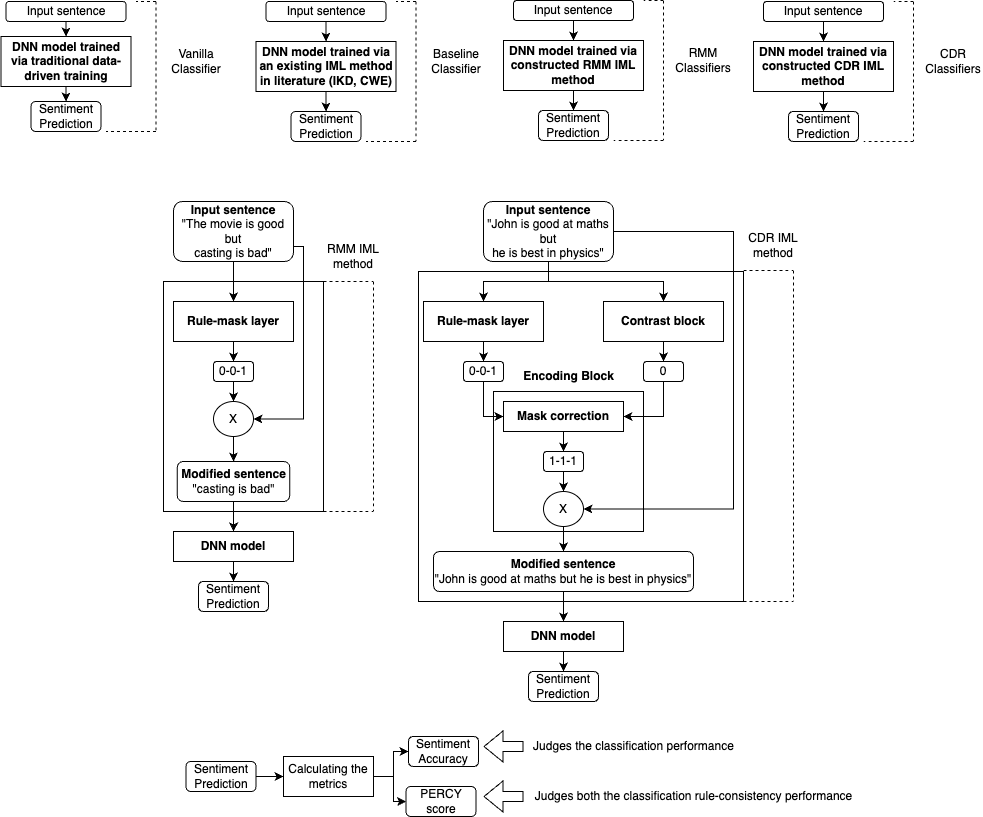

In [7]:
from IPython.display import Image
Image(filename='results_figure.png')
# #TO-DO: -
#i)Add an example to demonstrate what kind of performance is judged by each metric regarding the sentiment prediction
#ii)Within each block of your method, add paramters to show whether they are trainable or not
#iii)Add a dataset description figure. Provide an example to demonstrate better understanding of each category of distribution set

In [8]:
##### Tabular view of results #####
#Provide a small description of the tables
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args, titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>']))):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        if ' \n ' in title:
            titles = title.split(' \n ')
            for title in titles:
                html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        else:
            html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
display_side_by_side(dataframe_accuracy,
                     titles=['Sentiment accuracy'])
display_side_by_side(dataframe_percy, dataframe_percy_old, dataframe_percy_without_pval,
                     titles=['PERCY score \n (different condition for no-contrast)', 'PERCY score \n (with pval)', 'PERCY score \n (without pval)'])
display_side_by_side(dataframe_rule_mask_accuracy_old_method,dataframe_rule_mask_accuracy,
                     titles=["Rule-mask accuracy \n (vector comparison)","Rule-mask accuracy \n (tokenwise comparison)"])

,Sentiment classifiers,GRU,BiGRU,LSTM,BiLSTM
0,Vanilla classifiers,0.964,0.966,0.956,0.954
1,Baseline classifiers,-,-,-,-
2,FE (2021),0.946,0.944,0.94,0.936
3,RMM classifiers,-,-,-,-
4,GRU-mask,0.971,0.973,0.97,0.964
5,BiGRU-mask,0.968,0.975,0.962,0.961
6,LSTM-mask,0.973,0.971,0.971,0.959
7,BiLSTM-mask,0.967,0.974,0.97,0.963
8,CDR classifiers,-,-,-,-
9,GRU-mask+GRU-contrast,0.962,0.956,0.943,0.96


,Sentiment classifiers,GRU,BiGRU,LSTM,BiLSTM
0,Vanilla classifiers,0.872,0.884,0.882,0.868
1,Baseline classifiers,-,-,-,-
2,FE (2021),0.0,0.0,0.0,0.0
3,RMM classifiers,-,-,-,-
4,GRU-mask,0.891,0.898,0.894,0.892
5,BiGRU-mask,0.875,0.898,0.871,0.882
6,LSTM-mask,0.887,0.89,0.891,0.884
7,BiLSTM-mask,0.873,0.893,0.881,0.88
8,CDR classifiers,-,-,-,-
9,GRU-mask+GRU-contrast,0.877,0.863,0.844,0.881


,Sentiment classifiers,GRU,BiGRU,LSTM,BiLSTM
0,RMM classifiers,-,-,-,-
1,GRU-mask,0.643,0.634,0.602,0.575
2,BiGRU-mask,0.181,0.313,0.198,0.23
3,LSTM-mask,0.653,0.619,0.631,0.63
4,BiLSTM-mask,0.22,0.297,0.339,0.314
5,CDR classifiers,-,-,-,-
6,GRU-mask+GRU-contrast,0.656,0.662,0.621,0.643
7,BiGRU-mask+BiGRU-contrast,0.652,0.655,0.586,0.662
8,LSTM-mask+LSTM-contrast,0.556,0.59,0.564,0.57
9,BiLSTM-mask+BiLSTM-contrast,0.609,0.551,0.601,0.592


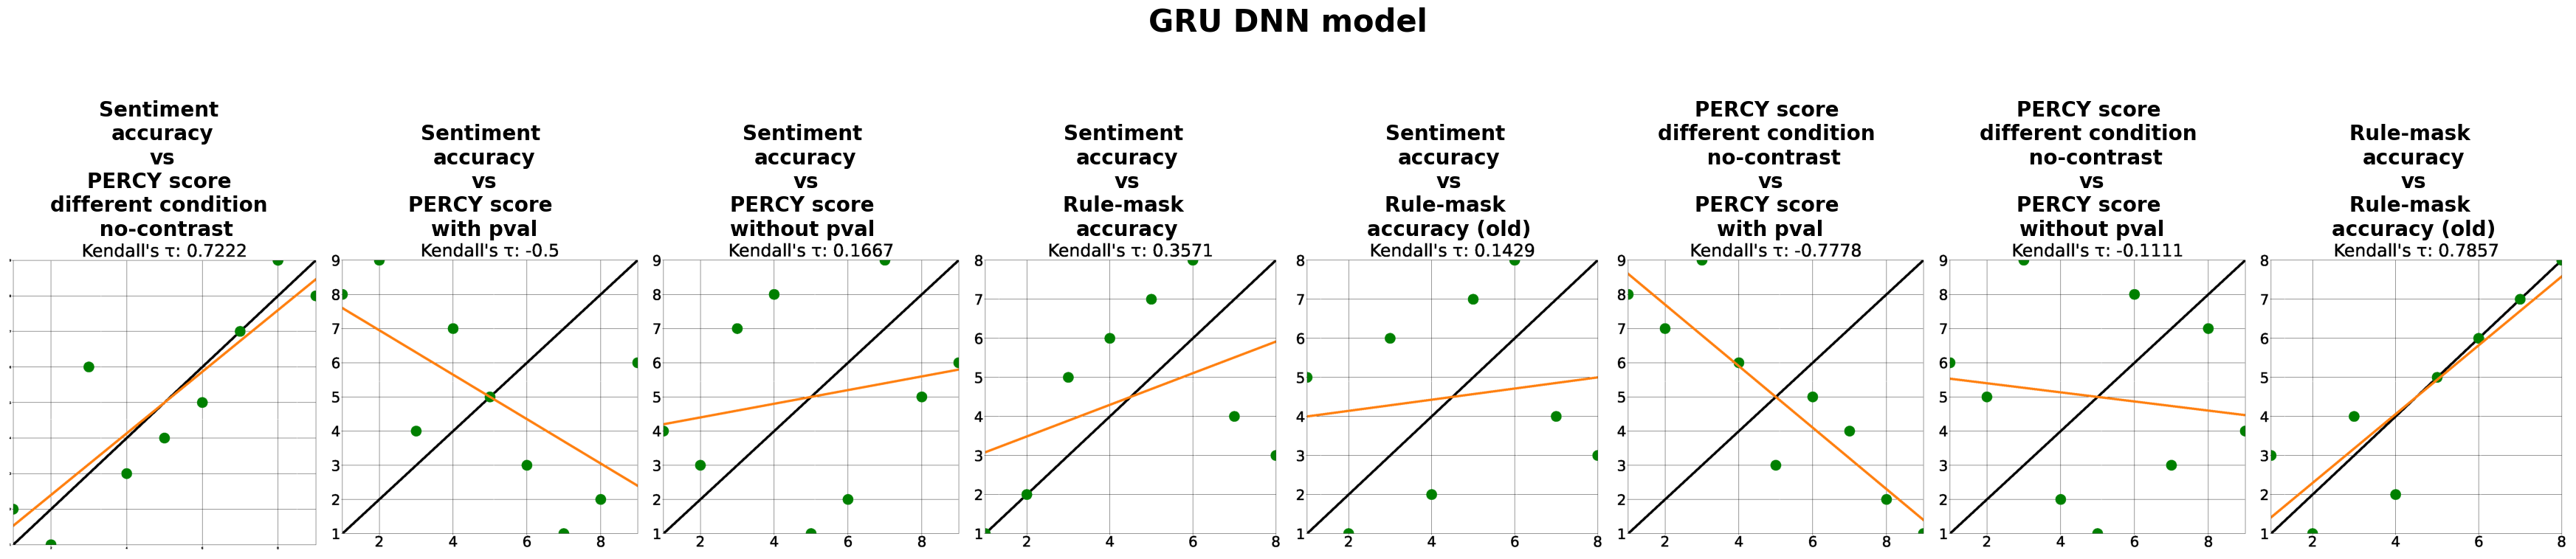

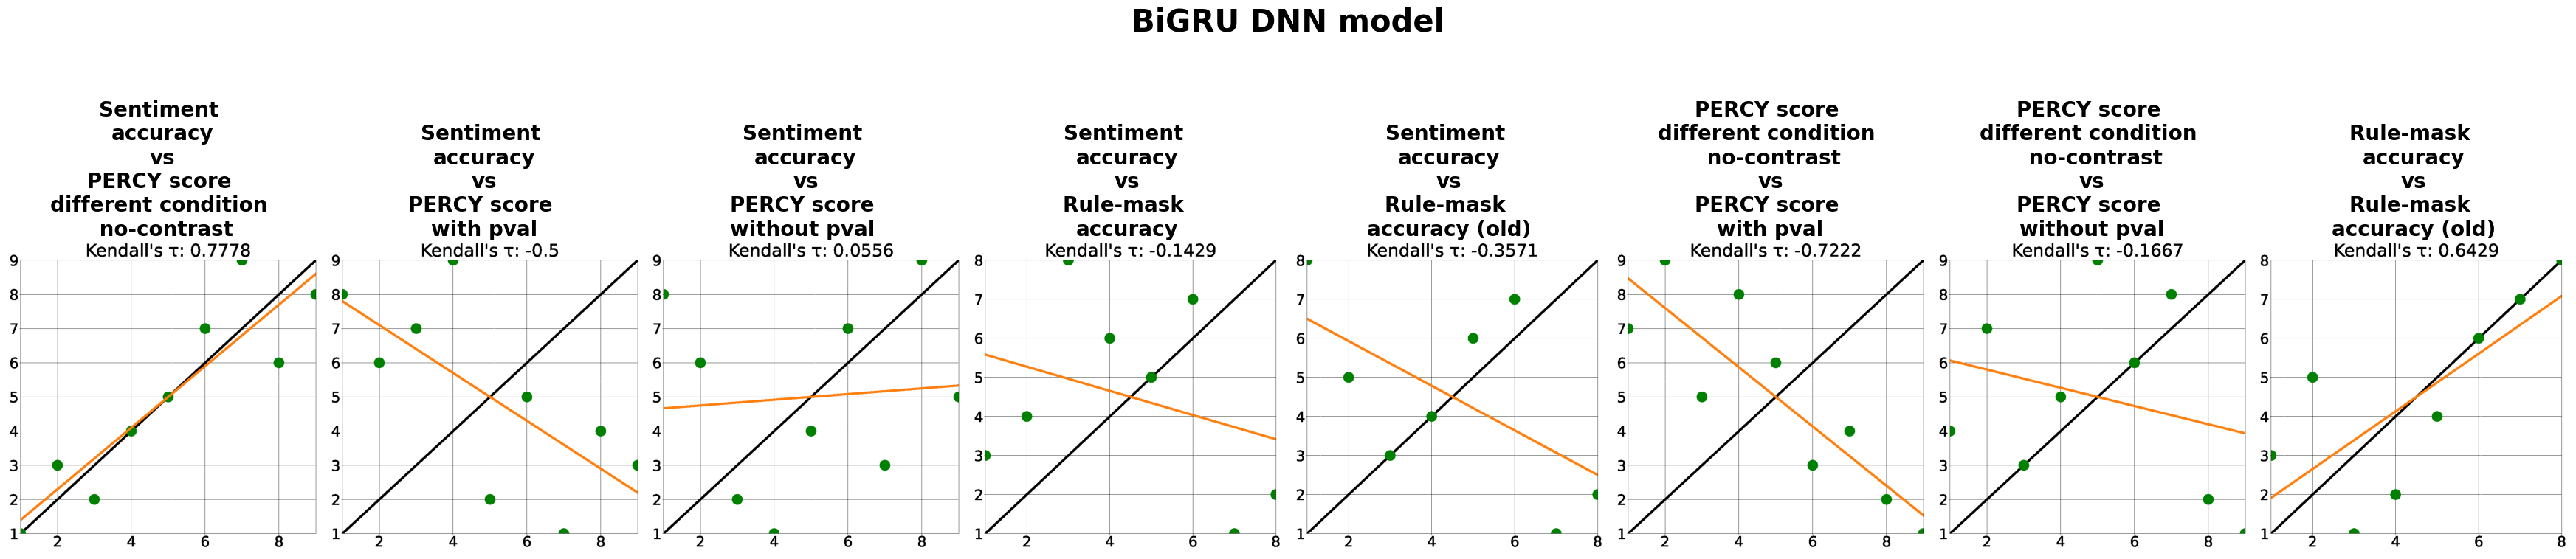

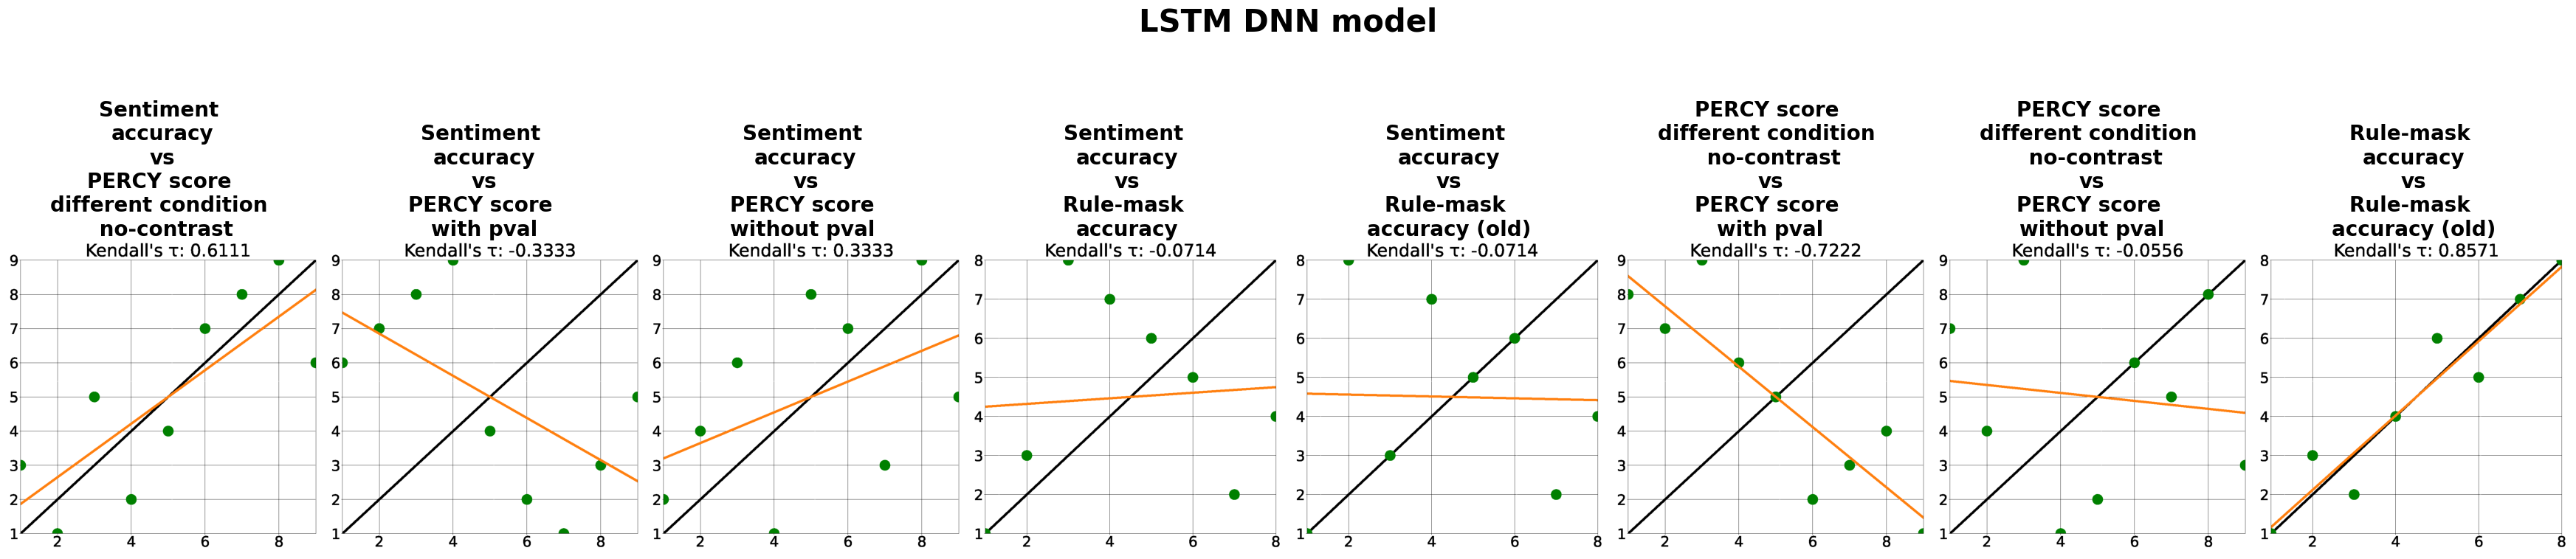

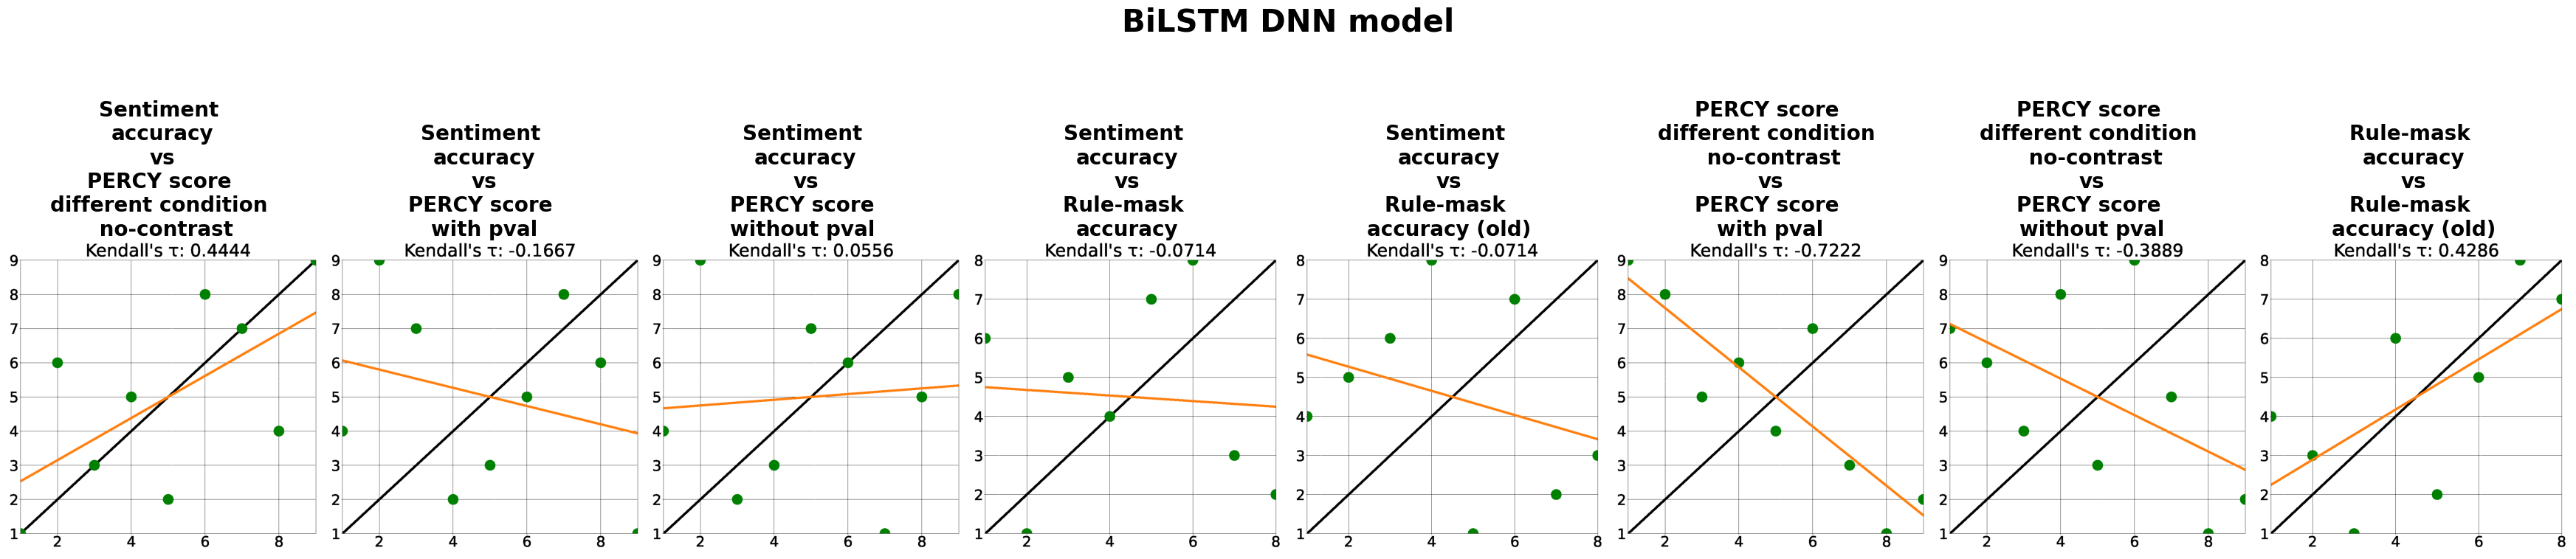

In [12]:
#### CORRELATION PLOTS (DO NOT USE FE model values since you do not have PERCY scores for them) ####
# CONDENSE THESE PLOTS: Their purpose is to show correlation between mertrics
# NO NEED ANYMORE: Keep them same

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams

# %matplotlib inline

# figure size in inches optional
rcParams['figure.figsize'] = 20, 20

# read images
DNN_MODELS = ["GRU", "BiGRU", "LSTM", "BiLSTM"]
for dnn_model in DNN_MODELS:
    
    fig, ax = plt.subplots(1,8, constrained_layout=True, figsize=(35, 10))
    fig.suptitle(dnn_model+" DNN model", x=0.5, y=1.0, weight="bold", fontsize=30)
    
    img_A = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_score_vs_sentiment_accuracy_ranked_corr_plots.eps")
    ax[0].imshow(img_A)
    ax[0].axis('off')
    ax[0].set_title("Sentiment \naccuracy\nvs\nPERCY score \ndifferent condition \n no-contrast", weight="bold", x=0.5, y=1.0, fontsize=20)
    
    img_B = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_old_score_vs_sentiment_accuracy_ranked_corr_plots.eps")
    ax[1].imshow(img_B)
    ax[1].axis('off')
    ax[1].set_title("Sentiment \naccuracy\nvs\nPERCY score \nwith pval", weight="bold", x=0.5, y=1.0, fontsize=20)
    
    img_C = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_without_pval_score_vs_sentiment_accuracy_ranked_corr_plots.eps")
    ax[2].imshow(img_C)
    ax[2].axis('off')
    ax[2].set_title("Sentiment \naccuracy\nvs\nPERCY score \nwithout pval ", weight="bold", x=0.5, y=1.0, fontsize=20)
    
    img_D = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_vs_sentiment_accuracy_ranked_corr_plots.eps")
    ax[3].imshow(img_D)
    ax[3].axis('off')
    ax[3].set_title("Sentiment \naccuracy\nvs\nRule-mask \naccuracy", weight="bold", x=0.5, y=1.0, fontsize=20)
    
    img_E = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_old_vs_sentiment_accuracy_ranked_corr_plots.eps")
    ax[4].imshow(img_E)
    ax[4].axis('off')
    ax[4].set_title("Sentiment \naccuracy\nvs\nRule-mask \naccuracy (old)", weight="bold", x=0.5, y=1.0, fontsize=20)
    
    img_F = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_score_vs_percy_old_score_ranked_corr_plots.eps")
    ax[5].imshow(img_F)
    ax[5].axis('off')
    ax[5].set_title("PERCY score \ndifferent condition \n no-contrast\nvs\nPERCY score \nwith pval", weight="bold", x=0.5, y=1.0, fontsize=20)
    
    img_G = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_score_vs_percy_without_pval_score_ranked_corr_plots.eps")
    ax[6].imshow(img_G)
    ax[6].axis('off')
    ax[6].set_title("PERCY score \ndifferent condition \n no-contrast\nvs\nPERCY score \nwithout pval", weight="bold", x=0.5, y=1.0, fontsize=20)
    
    img_H = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_old_vs_rule_mask_accuracy_ranked_corr_plots.eps")
    ax[7].imshow(img_H)
    ax[7].axis('off')
    ax[7].set_title("Rule-mask \naccuracy\nvs\nRule-mask \naccuracy (old)", weight="bold", x=0.5, y=1.0, fontsize=20)
    
    fig.tight_layout()

In [ ]:
# ########### Bar-plots view of the results ############

# models = ["GRU", "BiGRU", "LSTM", "BiLSTM"]
# clrs = ["darkturquoise", "limegreen", "yellow", "lightcoral", "orange", "violet"]
# #["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey", "darkturquoise", "olive"]

# params = {'axes.labelsize': 30,
#             'axes.titlesize': 30,
#             'xtick.labelsize': 30,
#             'ytick.labelsize': 30,
#             'axes.titlepad': 12,
#             'axes.axisbelow': True,
#             'text.usetex': False,
#             'text.latex.preamble': r'\usepackage{amsmath}\usepackage{type1cm}'}
# plt.rcParams.update(params)
# fig_acc, axs = plt.subplots(6, 1, figsize=(20, 15))

# # Bar Plots
# for ind, (ax, model) in enumerate(zip(axs, models)):
    
#     ax.yaxis.grid(True)
#     ax.set_title(model, x=0.06, y=0.75, fontweight='bold')
    
#     if SHOW_RESULTS == "accuracy" or SHOW_RESULTS == "percy":
#         labels = ["Base", "IKD", "CWE", "GRU\nmask", "BiGRU\nmask", "LSTM\nmask", "BiLSTM\nmask"]
#     elif SHOW_RESULTS == "rule_mask" or SHOW_RESULTS == "contrast":
#         labels = ["GRU\nmask", "BiGRU\nmask", "LSTM\nmask", "BiLSTM\nmask"]
    
#     width = 0.9
#     x_coordinates = [index for index, value in enumerate(labels)]
    
#     colors = iter([clrs[ind]]*(len(labels)))
    
#     rnn = globals()[model]
    
#     for index, _ in enumerate(labels):
#         x_coordinate = x_coordinates[index]
#         mean = rnn[index]
#         max_val_index = rnn.index(max(rnn))
#         stat_similar_val_indices = []
#         for i, val in enumerate(rnn):
#             if max(rnn)-val < 0.03 and max(rnn)-val != 0.0:
#                 stat_similar_val_indices.append(i)
#         color = next(colors)
#         bars = ax.bar(x_coordinate, mean, width, edgecolor = 'black', linewidth = 1, color=color)
#     #     error_bars = ax.errorbar(x_coordinate, mean, yerr=std_dev, fmt='o', marker='.', capsize=3, capthick=1, markersize=3, elinewidth=0, color='black')
#         for rect in bars:
#             height = rect.get_height()
#             if index == max_val_index:
#                 ax.text(x=rect.get_x() + rect.get_width() / 2, y=height-0.06, s="{}".format(height), ha='center', fontsize='30', rotation=0, weight='bold')
# #             elif index in stat_similar_val_indices:
# #                 value = str(height)
# # #                 print(value)
# #                 ax.text(x=rect.get_x() + rect.get_width() / 2, y=height+0.02, s=r'$\underline{'+value+'}$', ha='center', fontsize='30', rotation=0, usetex=True)
#             else:
#                 ax.text(x=rect.get_x() + rect.get_width() / 2, y=height-0.06, s="{}".format(height), ha='center', fontsize='30', rotation=0)

#     #     ax.plot(correct_means, '-o', color='black', linewidth=3)
#     if model == "GRU":
#         if SHOW_RESULTS == "percy":
#             ax.set_ylabel('PERCY scores', fontweight='bold')
#             ax.yaxis.set_label_coords(-0.06, -0.4)
#         elif SHOW_RESULTS == "accuracy":
#             ax.set_ylabel('Accuracy', fontweight='bold')
#             ax.yaxis.set_label_coords(-0.06, -0.4)
#         elif SHOW_RESULTS == "rule_mask":
#             ax.set_ylabel('Rule-Mask accuracy', fontweight='bold')
#             ax.yaxis.set_label_coords(-0.06, -0.4)
#         elif SHOW_RESULTS == "contrast":
#             ax.set_ylabel('Contrast accuracy', fontweight='bold')
#             ax.yaxis.set_label_coords(-0.06, -0.4)
#     ax.set_xticks(x_coordinates)
#     ax.set_xticks(x_coordinates)
#     ax.set_xticks(x_coordinates)
#     if model == "BiLSTM":
#         ax.set_xticklabels(labels, rotation=0, ha="center")
#     ax.set_xlim(-1, len(labels))
#     ax.set_ylim(0.01, 1.0)
    
#     if model != "BiLSTM":
#         ax.xaxis.set_visible(False)
#         ax.spines['bottom'].set_visible(False)

#     plt.tight_layout()
#     plt.subplots_adjust(left=0.2, bottom=None, right=None, top=None, wspace=None, hspace=0)

# # # Save fig
# # if not os.path.exists("analysis/WISE2023/"):
# #     os.makedirs("analysis/WISE2023/")
# # plt.savefig('analysis/WISE2023/bar_plots.eps', bbox_inches = 'tight')

# # Display fig
# plt.show()

In [17]:
# #### One rule contrast ####
# # CONDENSE THESE PLOTS: Their purpose is to show correlation between mertrics
# # NO NEED ANYMORE: Keep them same

# import matplotlib.pyplot as plt
# import matplotlib.image as mpimg
# from matplotlib import rcParams

# # %matplotlib inline

# # figure size in inches optional
# rcParams['figure.figsize'] = 20, 20

# # read images
# DNN_MODELS = ["GRU", "BiGRU", "LSTM", "BiLSTM"]
# for dnn_model in DNN_MODELS:
    
#     fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(35, 7))
#     fig.suptitle(dnn_model+" DNN model", x=0.5, y=0.8, weight="bold", fontsize=30)
    
#     img_A = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_score_vs_sentiment_accuracy_ranked_corr_plots.eps")
#     ax[0].imshow(img_A)
#     ax[0].axis('off')
#     ax[0].set_title("Sentiment \naccuracy\nvs\nPERCY score \ndifferent condition \n no-contrast", weight="bold", x=0.5, y=1.0, fontsize=20)
    
#     img_B = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_old_score_vs_sentiment_accuracy_ranked_corr_plots.eps")
#     ax[1].imshow(img_B)
#     ax[1].axis('off')
#     ax[1].set_title("Sentiment \naccuracy\nvs\nPERCY score \nwith pval", weight="bold", x=0.5, y=1.0, fontsize=20)
    
#     img_C = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_without_pval_score_vs_sentiment_accuracy_ranked_corr_plots.eps")
#     ax[2].imshow(img_C)
#     ax[2].axis('off')
#     ax[2].set_title("Sentiment \naccuracy\nvs\nPERCY score \nwithout pval ", weight="bold", x=0.5, y=1.0, fontsize=20)
    
#     fig.tight_layout()
    
#     fig, ax = plt.subplots(1,2, constrained_layout=True, figsize=(35, 7))
    
#     img_D = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_vs_sentiment_accuracy_ranked_corr_plots.eps")
#     ax[0].imshow(img_D)
#     ax[0].axis('off')
#     ax[0].set_title("Sentiment \naccuracy\nvs\nRule-mask \naccuracy", weight="bold", x=0.5, y=1.0, fontsize=20)
    
#     img_E = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_old_vs_sentiment_accuracy_ranked_corr_plots.eps")
#     ax[1].imshow(img_E)
#     ax[1].axis('off')
#     ax[1].set_title("Sentiment \naccuracy\nvs\nRule-mask \naccuracy (old)", weight="bold", x=0.5, y=1.0, fontsize=20)
    
#     fig.tight_layout()
    
#     fig, ax = plt.subplots(1,3, constrained_layout=True, figsize=(35, 7))
    
#     img_F = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_score_vs_percy_old_score_ranked_corr_plots.eps")
#     ax[0].imshow(img_F)
#     ax[0].axis('off')
#     ax[0].set_title("PERCY score \ndifferent condition \n no-contrast\nvs\nPERCY score \nwith pval", weight="bold", x=0.5, y=1.0, fontsize=20)
    
#     img_G = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_percy_score_vs_percy_without_pval_score_ranked_corr_plots.eps")
#     ax[1].imshow(img_G)
#     ax[1].axis('off')
#     ax[1].set_title("PERCY score \ndifferent condition \n no-contrast\nvs\nPERCY score \nwithout pval", weight="bold", x=0.5, y=1.0, fontsize=20)
    
#     img_H = mpimg.imread("analysis/ECIR2024/"+SUBSET+"_"+dnn_model+"_rule_mask_accuracy_old_vs_rule_mask_accuracy_ranked_corr_plots.eps")
#     ax[2].imshow(img_H)
#     ax[2].axis('off')
#     ax[2].set_title("Rule-mask \naccuracy\nvs\nRule-mask \naccuracy (old)", weight="bold", x=0.5, y=1.0, fontsize=20)
    
#     fig.tight_layout()

Text(0, 0.5, 'Sentiment Acc.')

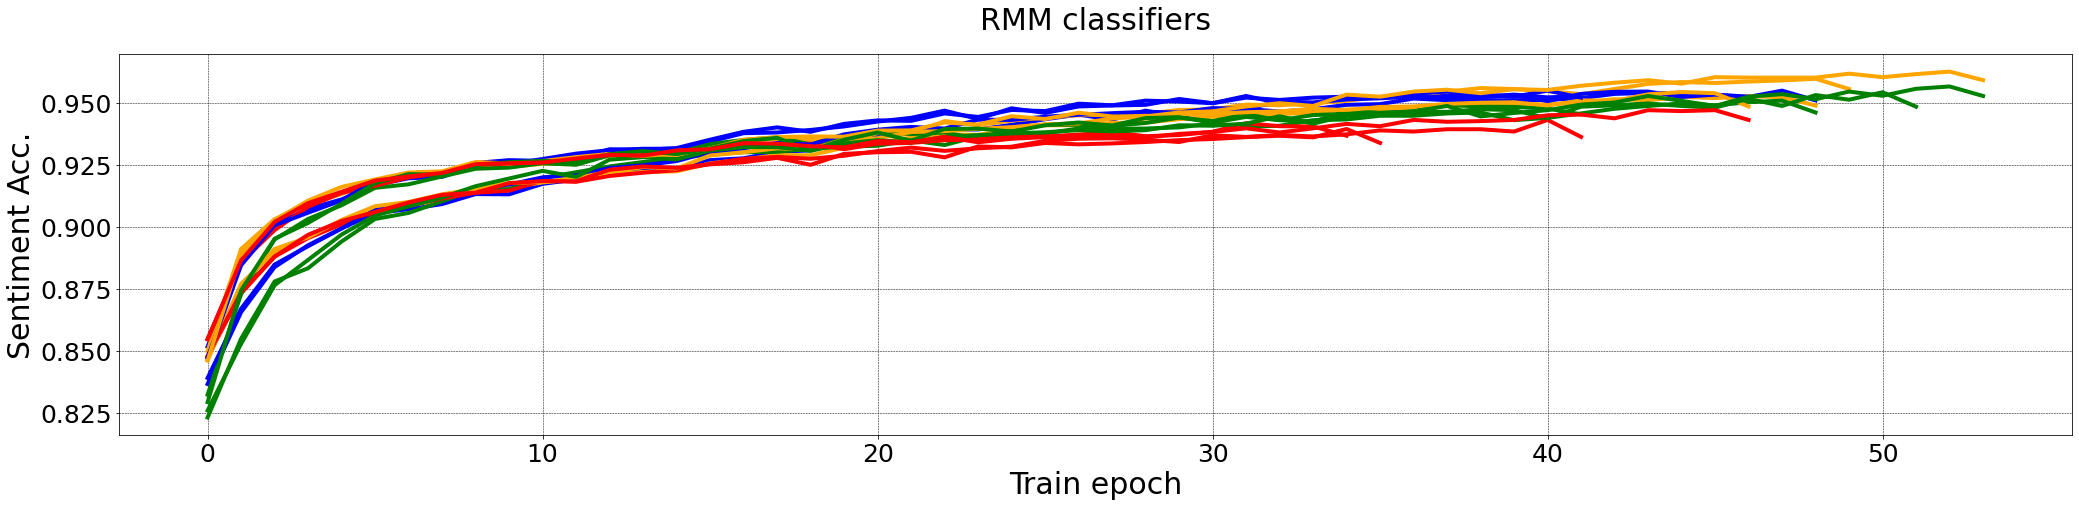

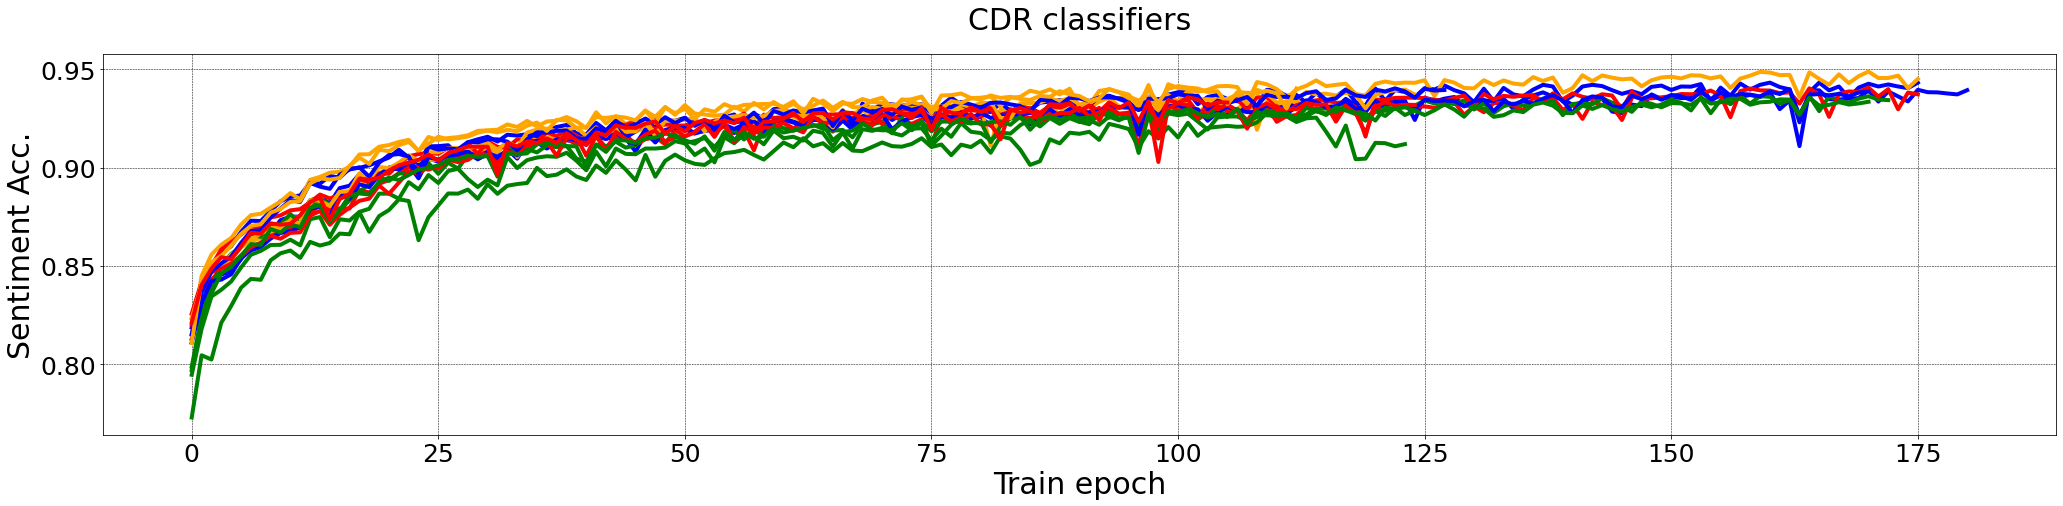

In [11]:
##### Convergence plots #####

# smoothening
def smooth(scalars, weight = 0.0):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

# Graph parameters
params = {'figure.titlesize':30,
          'legend.fontsize': 25,
          'font.size': 25,
          'axes.labelsize': 30,
          'axes.titlesize':30,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'axes.titlepad': 25,
          'axes.axisbelow': True}
plt.rcParams.update(params)

#RMM configurations
fig_rmm, ax_rmm = plt.subplots(figsize=(35, 7))
ax_rmm.grid(color = 'black', linestyle = '--', linewidth = 0.5)
for index, mask_model in enumerate(mask_models):
    colors = ["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey"]
    for index_2, model in enumerate(mask_model):
        color = colors[index_2]
        with open("mask_model/assets/training_history/"+model+".pickle", 'rb') as handle:
            history = pickle.load(handle)
        history['test_dataset_one_rule_output_accuracy_smoothed'] = smooth(history['test_dataset_one_rule_output_accuracy'])
        ax_rmm.plot(history['test_dataset_one_rule_output_accuracy_smoothed'], color=color, linewidth=4)
ax_rmm.set_title('RMM classifiers')
ax_rmm.set_xlabel('Train epoch')
ax_rmm.set_ylabel('Sentiment Acc.')

#CDRM configurations
fig_cdrm, ax_cdrm = plt.subplots(figsize=(35, 7))
ax_cdrm.grid(color = 'black', linestyle = '--', linewidth = 0.5)
for index, mask_contrast_model in enumerate(mask_contrast_models):
    colors = ["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey"]
    for index_2, model in enumerate(mask_contrast_model):
        color = colors[index_2]
        with open("mask_contrast_model/assets/training_history/"+model+".pickle", 'rb') as handle:
            history = pickle.load(handle)
        history['test_dataset_one_rule_output_accuracy_smoothed'] = smooth(history['test_dataset_one_rule_output_accuracy'])
        ax_cdrm.plot(history['test_dataset_one_rule_output_accuracy_smoothed'], color=color, linewidth=4)
ax_cdrm.set_title("CDR classifiers")
ax_cdrm.set_xlabel('Train epoch')
ax_cdrm.set_ylabel('Sentiment Acc.')

Text(0, 0.5, 'Rule-mask Acc.')

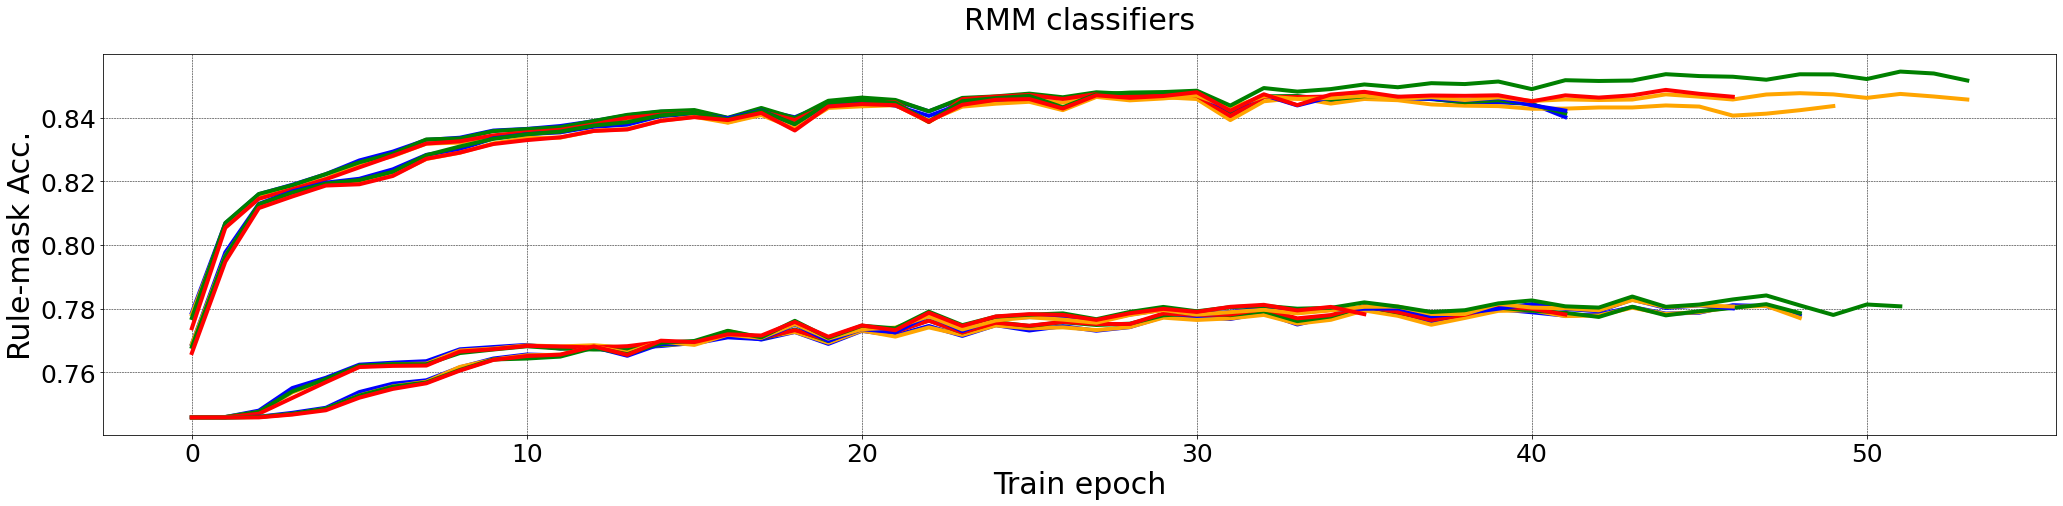

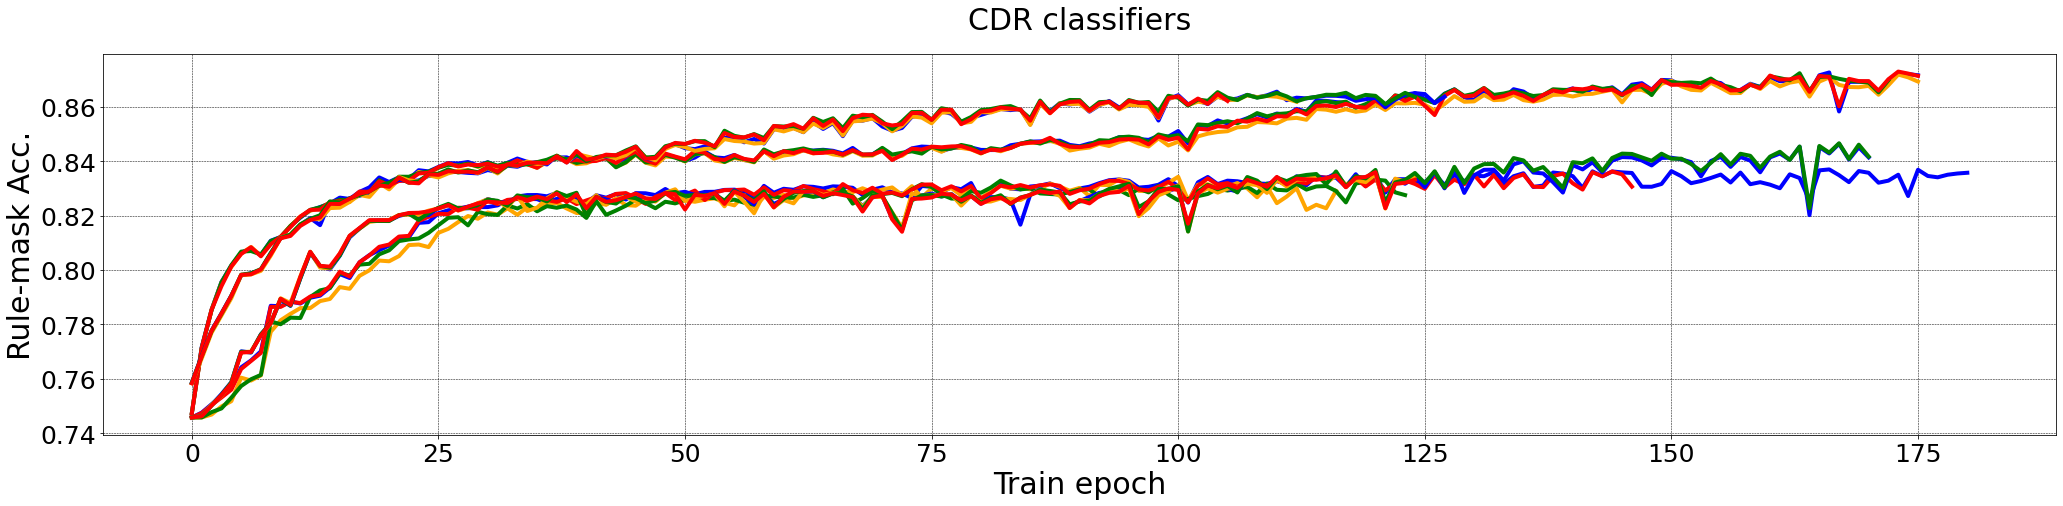

In [12]:
##### Convergence plots #####

# smoothening
def smooth(scalars, weight = 0.0):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

# Graph parameters
params = {'figure.titlesize':30,
          'legend.fontsize': 25,
          'font.size': 25,
          'axes.labelsize': 30,
          'axes.titlesize':30,
          'xtick.labelsize': 25,
          'ytick.labelsize': 25,
          'axes.titlepad': 25,
          'axes.axisbelow': True}
plt.rcParams.update(params)

#RMM configurations
fig_rmm, ax_rmm = plt.subplots(figsize=(35, 7))
ax_rmm.grid(color = 'black', linestyle = '--', linewidth = 0.5)
for index, mask_model in enumerate(mask_models):
    colors = ["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey"]
    for index_2, model in enumerate(mask_model):
        color = colors[index_2]
        with open("mask_model/assets/training_history/"+model+".pickle", 'rb') as handle:
            history = pickle.load(handle)
        history['test_dataset_one_rule_mask_accuracy_smoothed'] = smooth(history['test_dataset_one_rule_mask_accuracy'])
        ax_rmm.plot(history['test_dataset_one_rule_mask_accuracy_smoothed'], color=color, linewidth=4)
ax_rmm.set_title('RMM classifiers')
ax_rmm.set_xlabel('Train epoch')
ax_rmm.set_ylabel('Rule-mask Acc.')

#CDRM configurations
fig_cdrm, ax_cdrm = plt.subplots(figsize=(35, 7))
ax_cdrm.grid(color = 'black', linestyle = '--', linewidth = 0.5)
for index, mask_contrast_model in enumerate(mask_contrast_models):
    colors = ["blue", "orange", "green", "red", "limegreen", "brown", "magenta", "grey"]
    for index_2, model in enumerate(mask_contrast_model):
        color = colors[index_2]
        with open("mask_contrast_model/assets/training_history/"+model+".pickle", 'rb') as handle:
            history = pickle.load(handle)
        history['test_dataset_one_rule_binomial_accuracy_smoothed'] = smooth(history['test_dataset_one_rule_binomial_accuracy'])
        ax_cdrm.plot(history['test_dataset_one_rule_binomial_accuracy_smoothed'], color=color, linewidth=4)
ax_cdrm.set_title("CDR classifiers")
ax_cdrm.set_xlabel('Train epoch')
ax_cdrm.set_ylabel('Rule-mask Acc.')

In [ ]:
# df = dataframe_accuracy
# df

In [ ]:
# df.columns = ["Sentiment classifiers", "DNN models", "", "", ""]
# first_row = ["Vanilla classifiers", 0.952, 0.953, 0.936, 0.934]
# df.data.loc[0] = ["", "GRU", "BiGRU", "LSTM", "BiSLSTM"]
# # df.data.loc[0.5] = first_row
# # df.data = df.data.sort_index().reset_index(drop=True)
# df

In [ ]:
# Generate the Latex code for tabular view of the results => It is very handy and easy to put results in the draft without any errors
from scipy.stats import ttest_ind
import numpy as np

values = sentiment_accuracy
distributions = sentiment_accuracy_distributions

columns = []
for index, classifier in enumerate(values):
    distribution = distributions[index]
    column = []
    highest_value = max(classifier)
    highest_value_index = classifier.index(highest_value)
    highest_value_dist = distribution[highest_value_index]
    pvals_to_highest_val = []
    for dist in distribution:
        ttest, pval = ttest_ind(highest_value_dist, dist)
        pvals_to_highest_val.append(pval)
    for index, value in enumerate(classifier):
        pval = pvals_to_highest_val[index]
        if pval == 1:
            val = "&"+r"\textbf{"+str(value)+"}"
            column.append(val)
        elif pval > 0.05 and pval!=1:
            val = "&"+r"\underline{"+str(value)+"}"
            column.append(val)
        else:
            val = "&"+str(value)
            column.append(val)
    columns.append(column)

columns_np = np.array(columns)
columns_np_transpose = columns_np.transpose()

for col in columns_np_transpose:
    print(col)

In [ ]:
with open("base_model_FE/assets/results/gru_FE_model-MODEL_MODIFIED_FOR_PERCY_CALCULATION-TRAINED_ON_SERVER.pickle", 'rb') as handle:
    results = pickle.load(handle)
    results = pd.DataFrame(results)
with open("base_model_FE/assets/lime_explanations/bigru_FE_model-MODEL_MODIFIED_FOR_PERCY_CALCULATION-TRAINED_ON_SERVER.pickle", 'rb') as handle:
    results_lime_explanations = pickle.load(handle)
    results_lime_explanations = pd.DataFrame(results_lime_explanations)
    print(results_lime_explanations)
#     calculating_metrics_and_distributions(model, results)
# results_lime_explanations

In [ ]:
results.loc[results["rule_label"]!=0]

In [ ]:
# smoothening
def smooth(scalars, weight = 0.0):  # Weight between 0 and 1
    last = scalars[0]  # First value in the plot (first timestep)
    smoothed = list()
    for point in scalars:
        smoothed_val = last * weight + (1 - weight) * point  # Calculate smoothed value
        smoothed.append(smoothed_val)                        # Save it
        last = smoothed_val                                  # Anchor the last smoothed value
    return smoothed

fig_rmm, ax_rmm = plt.subplots(figsize=(35, 7))
ax_rmm.grid(color = 'black', linestyle = '--', linewidth = 0.5)
colors = ["blue", "orange", "green", "red"]
for index, model in enumerate(fe):
    color = colors[index]
    with open("base_model_FE/assets/training_history/"+model+".pickle", 'rb') as handle:
        history = pickle.load(handle)
    history['test_dataset_one_rule_output_accuracy_smoothed'] = smooth(history['test_dataset_one_rule_accuracy'])
    ax_rmm.plot(history['test_dataset_one_rule_output_accuracy_smoothed'], color=color, linewidth=4)
ax_rmm.set_title('FE classifiers')
ax_rmm.set_xlabel('Train epoch')
ax_rmm.set_ylabel('Sentiment Acc.')